In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int):      0-based subject ID to load
    experiment (str):   Name of experiment 
    run (int):          0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = EXPERIMENTS[experiment]['runs'][run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list



In [12]:
def average_frames_win( data , evs, experiment, cond):    
            idx = EXPERIMENTS[experiment]['cond'].index(cond)
            ts_i = np.mean(np.concatenate([np.mean(data[:,evs[idx][i]],axis=1,keepdims=True) for i in range(len(evs[idx]))],axis=-1),axis=1)
            return ts_i

        
my_exp  = 'GAMBLING'
my_run  = 0
def makeWinDataForAllSubjects():
    NumberofSubjects = 339
    subjects = range(NumberofSubjects)
    tsAll = np.array([])
    conditionWin = 'win'
    my_exp  = 'GAMBLING'
    my_subj = 0
    my_run  = 0
    
        
    for i in subjects:
        data = load_single_timeseries(subject=i, experiment=my_exp,run=my_run,remove_mean=True)
        evs = load_evs(subject=i, experiment=my_exp,run=my_run)
        tsi = average_frames_win(data, evs, my_exp , cond=conditionWin)
        tsAll = np.concatenate((tsAll, tsi))
    return tsAll

        
tsWinData = makeWinDataForAllSubjects()
tsWinData = tsWinData.reshape(339,-1)
tsWinData.shape

(339, 360)

In [27]:
def makelossDataForAllSubjects():
    NumberofSubjects = 339
    subjects = range(NumberofSubjects)
    tsAll = np.array([])
    conditionloss = 'loss'
    my_exp  = 'GAMBLING'
    my_subj = 0
    my_run  = 1
    
        
    for i in subjects:
        data = load_single_timeseries(subject=i, experiment=my_exp,run=my_run,remove_mean=True)
        evs = load_evs(subject=i, experiment=my_exp,run=my_run)
        tsi = average_frames_win(data, evs, my_exp , cond=conditionloss)
        tsAll = np.concatenate((tsAll, tsi))
    return tsAll

        
tslossData = makelossDataForAllSubjects()
tslossData = tslossData.reshape(339,-1)
tslossData.shape



(339, 360)

In [28]:
#win = 1
#loss = 0
NumberofSubjects = 339
#make array of output values Y.
one = np.ones(NumberofSubjects)
zero = np.zeros(NumberofSubjects)

In [29]:
import math
subjectsTrainforWins = math.floor(NumberofSubjects*0.8) 
subjectsTrainforLoss = subjectsTrainforWins


In [30]:
X_trainWins = tsWinData[:subjectsTrainforWins]
y_trainWins = one[:subjectsTrainforWins]

X_testWins = tsWinData[subjectsTrainforWins:]
y_testWins = one[subjectsTrainforWins:]


X_trainLoss = tslossData[:subjectsTrainforLoss]
y_trainLoss = zero[:subjectsTrainforLoss]

X_testLoss = tslossData[subjectsTrainforLoss:]
y_testLoss = zero[subjectsTrainforLoss:]


X_train = np.concatenate((X_trainWins,X_trainLoss))

y_train = np.concatenate((y_trainWins,y_trainLoss))

X_test = np.concatenate((X_testWins,X_testLoss))
y_test = np.concatenate((y_testWins,y_testLoss))

print(f'X_train shape is {X_train.shape}\nX_test shape is {X_test.shape} \ny_train shape is {y_train.shape} \ny_test shape is {y_test.shape}')

X_train shape is (542, 360)
X_test shape is (136, 360) 
y_train shape is (542,) 
y_test shape is (136,)


In [31]:
scaler_X = StandardScaler()
f_transformer = scaler_X.fit(X_train)

X_train = f_transformer.transform(X_train)
X_test = f_transformer.transform(X_test)

In [32]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression()

In [33]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.8970588235294118


In [34]:
predictions = logisticRegr.predict(X_test)
ConfusionMatrix = metrics.confusion_matrix(y_test, predictions)
print(ConfusionMatrix)

[[61  7]
 [ 7 61]]


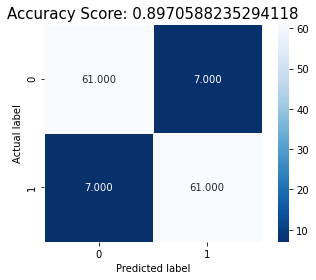

In [11]:
sns.heatmap(ConfusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [12]:
weights = np.ravel(logisticRegr.coef_)

<BarContainer object of 10 artists>

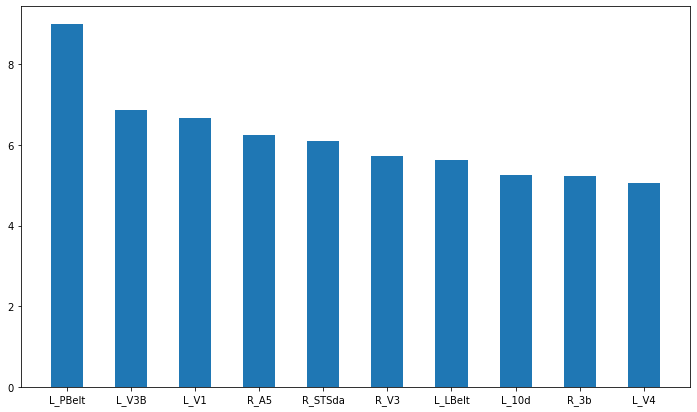

In [13]:
weights = weights*10
regionsWights = regions[0]

indices = (-weights).argsort()[:10]
plt.figure(figsize = (12,7))

plt.bar(regionsWights[indices] , weights[indices], width =0.5)



In [14]:
regionsWights[indices]

array(['L_PBelt', 'L_V3B', 'L_V1', 'R_A5', 'R_STSda', 'R_V3', 'L_LBelt',
       'L_10d', 'R_3b', 'L_V4'], dtype='<U12')

In [15]:
weights[indices]

array([8.98417913, 6.87635135, 6.66261241, 6.24877575, 6.08891474,
       5.72681184, 5.63442455, 5.24727285, 5.22351295, 5.06461458])

In [16]:
regions[1][indices]

array(['Auditory', 'Visual2', 'Visual1', 'Default', 'Default', 'Visual2',
       'Auditory', 'Posterior-Mu', 'Somatomotor', 'Visual2'], dtype='<U12')

In [17]:
indices

array([303, 198, 180, 124, 127,   4, 353, 251,   8, 185])

In [15]:
np.save('weights.npy', weights)